# Trabalho 1 - Inteligência Artificial

## Imports necessários

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.utils.validation import check_X_y
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.base import BaseEstimator

## Base de dados

### Matrícula: 2015100346
Dessa forma, devido ao final da matrícula ser 6, a base de dados será composta pelos 10 descritores de Fourier e os 7 descritores de Hu.

In [3]:
# Leitura dos dados
df = pd.read_csv('https://raw.githubusercontent.com/VitorBonella/PL-Dataset/main/dataset.csv',sep=";") 

# Transformando a coluna id no índice da tabela
df.set_index('id', inplace=True)

# Lista de descritores
FOURIER = ['df01', 'df02', 'df03', 'df04','df05', 'df06', 'df07', 'df08', 'df09', 'df10']
HU = ['i1', 'i2', 'i3', 'i4','i5', 'i6', 'i7']
HARALICK = ['probmax', 'energia', 'entropia', 'contraste','homogeneidade', 'correlacao']

# Descritores que serão usados nesse trabalho
dataset = df[FOURIER + HU] 

# Transformação dos dados de string para float devido ao uso da vírgula ao invés do ponto
dataset = dataset.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)

# Criação das classes baseada no tipo da lâmpada e na potência
classes = df['tipo_lampada'].str.replace(" ", "") + df['potencia'].astype(str) 

# Adiciona a classe ao data frame da base de dados
# dataset['classe'] = df['tipo_lampada'].str.replace(" ", "") + df['potencia'].astype(str) 

# Define a base de dados e as classes target
dataset_X = dataset
dataset_Y = classes

# from sklearn import datasets
# dataset = datasets.load_breast_cancer()
# dataset_X = dataset.data
# dataset_Y = dataset.target

print(classes)
dataset.head(2)


id
355    metalica400
356    metalica400
357    metalica400
358    metalica400
359    metalica400
          ...     
656    metalica250
657    metalica250
658    metalica250
659    metalica250
660    metalica250
Length: 297, dtype: object


,df01,df02,df03,df04,df05,df06,df07,df08,df09,df10,i1,i2,i3,i4,i5,i6,i7
id,,,,,,,,,,,,,,,,,
355,0.087961,0.054059,0.025210,0.027471,0.012834,0.008374,0.004592,0.005163,0.004747,0.003075,0.168084,0.000615,0.000131,5.717751e-05,3.808159e-09,-1.417337e-06,3.153370e-09
356,0.018333,0.064192,0.021335,0.028935,0.012263,0.011230,0.003566,0.005862,0.003746,0.003779,0.164507,0.001087,0.000043,1.011576e-08,-5.395931e-15,-6.859661e-11,3.907229e-15


# Cálculo dos resultados

In [4]:
def classification_report(scores):
    print(f'\nMédia: {scores.mean():.5f}, Desvio Padrão: {scores.std():.5f}')

    inf, sup = stats.norm.interval(0.95, loc=scores.mean(), 
                               scale=scores.std()/np.sqrt(len(scores)))
    
    print(f'Intervalo de confiança (95%): [{inf:.5f},{sup:.5f}]')

# ZeroR (ZR)

In [5]:
zR = DummyClassifier(random_state=11)

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', zR)])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_zR = cross_val_score(pipeline, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_zR)

classification_report(scores_zR)

[0.16666667 0.13333333 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.17241379 0.17241379 0.17241379 0.16666667 0.13333333
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.17241379
 0.17241379 0.17241379 0.16666667 0.13333333 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.17241379 0.17241379 0.17241379]

Média: 0.16506, Desvio Padrão: 0.01088
Intervalo de confiança (95%): [0.16116,0.16895]


# Bagging (BA)

In [6]:
grade = {'estimator__n_estimators':[3, 9, 15, 21]}

# TODO
# Talvez usar um estimador diferente no final do ensemble
# Opções: Decision Tree, Random Forest, K-Nearest Neighbors (KNN), Support Vector Machines (SVM)
bg = BaggingClassifier(estimator=GaussianNB(), random_state=11)

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', bg)])

gs = GridSearchCV(estimator=pipeline, param_grid=grade, scoring='accuracy', cv=4)

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_BA = cross_val_score(gs, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_BA)

classification_report(scores_BA)

[0.3        0.26666667 0.2        0.43333333 0.43333333 0.33333333
 0.2        0.27586207 0.4137931  0.48275862 0.3        0.23333333
 0.26666667 0.26666667 0.33333333 0.56666667 0.4        0.37931034
 0.37931034 0.31034483 0.26666667 0.5        0.2        0.4
 0.26666667 0.23333333 0.36666667 0.4137931  0.31034483 0.24137931]

Média: 0.33245, Desvio Padrão: 0.09350
Intervalo de confiança (95%): [0.29899,0.36591]


# AdaBoost (AB)

In [7]:
grade = {'estimator__n_estimators':[3, 9, 15, 21]}

# TODO
# Talvez usar um estimador diferente no final do ensemble
# Opções: Decision Tree, Random Forest, K-Nearest Neighbors (KNN), Support Vector Machines (SVM)
adb = AdaBoostClassifier(estimator=GaussianNB(), random_state=11)

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', adb)])

gs = GridSearchCV(estimator=pipeline, param_grid=grade, scoring='accuracy', cv=4)

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_AB = cross_val_score(gs, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_AB)

classification_report(scores_AB)

[0.46666667 0.16666667 0.33333333 0.33333333 0.23333333 0.2
 0.26666667 0.37931034 0.20689655 0.48275862 0.3        0.23333333
 0.4        0.26666667 0.46666667 0.26666667 0.2        0.51724138
 0.24137931 0.31034483 0.23333333 0.33333333 0.33333333 0.3
 0.33333333 0.2        0.36666667 0.27586207 0.34482759 0.4137931 ]

Média: 0.31352, Desvio Padrão: 0.09113
Intervalo de confiança (95%): [0.28091,0.34614]


# RandomForest (RF)

In [8]:
grade = {'randomForest__n_estimators': [3, 9, 15, 21]}

rF = RandomForestClassifier(random_state=11)

pipeline = Pipeline([('transformer', StandardScaler()), ('randomForest', rF)])

gs = GridSearchCV(estimator=pipeline, param_grid=grade, scoring='accuracy', cv = 4)

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_RF = cross_val_score(gs, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_RF)

classification_report(scores_RF)


[0.46666667 0.3        0.4        0.46666667 0.6        0.53333333
 0.4        0.65517241 0.51724138 0.5862069  0.5        0.53333333
 0.56666667 0.46666667 0.4        0.53333333 0.4        0.68965517
 0.48275862 0.4137931  0.63333333 0.6        0.33333333 0.5
 0.63333333 0.5        0.6        0.51724138 0.51724138 0.55172414]

Média: 0.50992, Desvio Padrão: 0.09314
Intervalo de confiança (95%): [0.47659,0.54325]


# Heterogeneous Pooling (HP)

In [28]:
class HeterogeneousPoolingClassifier(BaseEstimator):
    def __init__(self, n_samples):
        super().__init__()
        self.n_samples = n_samples
        
        # Lista com os classificadores treinados
        self.classifiers = []

        # Lista de classes ordenada de forma decrescente pela quantidade de aparições
        self.target_frequency_desc = []

    def fit(self, x_train, y_train):
        x_train, y_train = check_X_y(x_train, y_train)
        self.target_frequency_desc = self.get_target_frequency_desc(y_train)

        for i in range(self.n_samples):
            # A primeira iteração usa a base original para treinamento
            if i == 0:
                current_x_train, current_y_train = x_train, y_train
            else:
                # Base diferente da original usando resample
                current_x_train, current_y_train = resample(x_train, y_train, replace=True, random_state=i-1)

            dt_classifier = DecisionTreeClassifier(random_state=11)
            dt_classifier.fit(current_x_train, current_y_train)
            self.classifiers.append(dt_classifier)

            nb_classifier = GaussianNB()
            nb_classifier.fit(current_x_train, current_y_train)
            self.classifiers.append(nb_classifier)

            knn_classifier = KNeighborsClassifier()
            knn_classifier.fit(current_x_train, current_y_train)
            self.classifiers.append(knn_classifier)

    def predict(self, x_test):
        predictions = []
        
        # Faz a predição usando cada um dos classificadores treinados e guarda o resultado obtido
        for classifier in self.classifiers:
            predictions.append(classifier.predict(x_test))

        # Transpor o array faz com que cada linha da matriz sejam todas as predições de um único item
        predictions = np.transpose(predictions)

        # As classes mais frequentes dentre as predições de cada item
        predictions = [self.most_common_predictions(prediction) for prediction in predictions]

        # Em caso de empate nas predições de um item, 
        # escolhe a mais frequente em relação ao conjunto de teste original
        predictions = [self.get_final_prediction(prediction) for prediction in predictions]

        return predictions


    # --------------- Helper functions ---------------

    def get_target_frequency_desc(self, y_train):
        class_counts = Counter(y_train)
        sorted_classes = sorted(class_counts, key=class_counts.get, reverse=True)
        return np.array(sorted_classes)

    def most_common_predictions(self, item_predictions):
        # Conta a frequência de cada classe na lista de predições daquele item
        class_counts = Counter(item_predictions)

        # Determina a contagem máxima de ocorrências de uma classe
        max_count = max(class_counts.values())

        # Obtém todas as classes que possuem a contagem máxima
        most_common = [predicted_class for predicted_class, count in class_counts.items() if count == max_count]

        # Retorna apenas as predições mais frequentes
        return most_common
    
    def get_final_prediction(self, prediction_list):
        # Caso haja um empate entre as classes mais votadas, 
        # escolhe a que mais aparece no conjunto de teste
        if len(prediction_list) > 1:
            for target in self.target_frequency_desc:
                if target in prediction_list:
                    return target
        else:
            return prediction_list[0]



In [29]:
hp = HeterogeneousPoolingClassifier(2)

pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', hp)])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

scores_HP = cross_val_score(pipeline, dataset_X, dataset_Y, scoring='accuracy', cv = rkf)

# print(scores_HP)

classification_report(scores_HP)

[0.43333333 0.26666667 0.36666667 0.5        0.43333333 0.4
 0.5        0.4137931  0.37931034 0.62068966 0.4        0.5
 0.4        0.26666667 0.5        0.5        0.4        0.55172414
 0.44827586 0.37931034 0.56666667 0.53333333 0.26666667 0.46666667
 0.5        0.3        0.43333333 0.44827586 0.4137931  0.4137931 ]

Média: 0.43341, Desvio Padrão: 0.08604
Intervalo de confiança (95%): [0.40262,0.46420]


# Boxplot

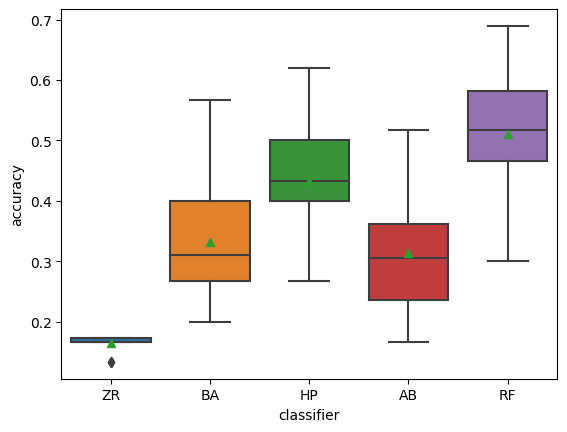

In [33]:
zR_scores_df = pd.DataFrame(scores_zR, columns=['accuracy']).assign(classifier='ZR')
ba_scores_df = pd.DataFrame(scores_BA, columns=['accuracy']).assign(classifier='BA')
ab_scores_df = pd.DataFrame(scores_AB, columns=['accuracy']).assign(classifier='AB')
rf_scores_df = pd.DataFrame(scores_RF, columns=['accuracy']).assign(classifier='RF')
hp_scores_df = pd.DataFrame(scores_HP, columns=['accuracy']).assign(classifier='HP')

boxplot = sns.boxplot(
    x='classifier',
    y='accuracy', 
    data=pd.concat([zR_scores_df, ba_scores_df, hp_scores_df,ab_scores_df, rf_scores_df ]),
    showmeans=True
)